In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
from optbinning import OptimalBinning
from itertools import zip_longest
from matplotlib.axes import Axes
import warnings
from typing import List, Optional

%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Loading

In [2]:
merchants = pd.read_csv("data/merchants.csv")
merchants=merchants.rename(columns={'country': 'merchant_country'})
merchants.head()

,merchant_id,category,merchant_country,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,M0001,travel,Austria,1.000000,3,97.23,84,0
1,M0002,clothing,Poland,0.689695,2,142.71,93,1
2,M0003,electronics,Czech Republic,0.834610,5,67.83,65,0
3,M0004,electronics,Belgium,0.607229,1,16.77,9,1
4,M0005,grocery,Ireland,0.641901,2,38.56,100,0


In [3]:
users = pd.read_csv("data/users.csv")
users=users.rename(columns={'country': 'user_country'})
users.head()

,user_id,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,user_country,signup_date,risk_score
0,U00001,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079
1,U00002,36,Female,Bachelor,Business,31.60,737.76,France,2020-07-07,0.705268
2,U00003,70,Other,High School,Student Aid,275.72,1477.50,Finland,2022-08-23,0.429579
3,U00004,38,Other,High School,Savings,288.29,1135.03,Belgium,2022-05-21,0.581384
4,U00005,61,Male,High School,Employment,7.00,892.76,Italy,2022-03-15,0.420227


In [4]:
transactions = pd.read_json("data/transactions.json", lines=True)
transactions.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,1,145,0,0
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,1,32,1,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,1,604,1,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,0,1031,1,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,1,330,0,0


# Exploratory Data Analysis

For the basic exploratory data analysis, the ProfileReport function from the ydata_profiling package was used. It generates a report containing key information about the dataset, such as the number of rows and columns, missing values, duplicates, variable types, histograms, and more. The reports were exported to HTML files, while the conclusions are presented below.

In [92]:
users_report = ProfileReport(users)
users_report.to_file("users_report.html")

merchants_report = ProfileReport(merchants)
merchants_report.to_file("merchants_report.html")

transactions_report = ProfileReport(transactions[["amount","channel","currency","device","payment_method","is_international","session_length_seconds","is_first_time_merchant","is_fraud"]])
transactions_report.to_file("transactions_report.html")

## Dataset *users*
**Excluded features**  
In the context of fraud detection, using certain types of personal data can be ethically sensitive or legally restricted. For example, including gender as a feature may lead to biased or discriminatory results. Consequently, this variable was deliberately excluded from the modeling pipeline.  

**Missing values**  
In dataset *users*, missing values occur in only one variable — education. For this type of variable, it is likely that the missingness is not random, as some individuals may, for example, be reluctant to share such personal information. Therefore, these missing values need to be properly addressed; simple solutions such as removing the affected observations are not appropriate in this case. For categorical variables, a good approach is to create a separate category for missing values, or even leave them as-is if using an algorithm that can handle them properly — for instance, XGBoost automatically treats missing values as a distinct category.  

**Categorical variables**  
There are four categorical variables in the dataset. Certain algorithms require these to be transformed — for instance, using one-hot encoding. In contrast, tree-based models can handle categorical features directly, making such transformation unnecessary.  

For most categorical variables, the number of observations is roughly balanced among the categories. The only exception is the country variable, where a single category, "Other values", significantly dominates the distribution.  

**Numerical variables**  
Among the four numerical variables, two exhibit skewed distributions. For some algorithms, especially those sensitive to the distribution of input features (e.g., linear models), it may be beneficial to apply transformations such as logarithmic scaling to normalize these variables.

## Dataset *merchants*
**Missing values**  
There are no missing values.  

**Categorical variables**  
There are three categorical variables in the dataset. Certain algorithms require these to be transformed — for instance, using one-hot encoding. In contrast, tree-based models can handle categorical features directly, making such transformation unnecessary.  

Both the category and country features are dominated by the "Other values" class.

**Numerical variables**  
Of the four numerical variables, one exhibits a pronounced skewed distribution, whereas two exhibit only mild skewness that is unlikely to cause issues.

## Dataset *transactions*
**Excluded features**  
The variable *currency* may be excluded from modeling as it exhibits only a single unique value.

**Missing values**  
There are no missing values. 

**Target Variable**

The variable *is_fraud* is imbalanced, with the majority of observations belonging to the negative class. The positive class accounts for approximately 8.5% of the observations. Such class imbalance is typical for fraud detection problems and should be carefully considered during model development.

**Categorical variables**  
Some categorical variables display a relatively uniform distribution across their categories, indicating an approximately equal number of observations per category. In contrast, other variables are dominated by a single prevailing category.

**Numerical variables**  
One numerical variable exhibits skewed distributions.

# Dataset Merging

In [5]:
transactions_with_user = pd.merge(transactions, users, on='user_id', how='left')
df_merged = pd.merge(transactions_with_user, merchants, on='merchant_id', how='left')

After joining all datasets, no new missing values appeared, which indicates that we have complete information about all users and merchants present in the transactions dataset.

In [99]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   location                        500000 non-null  object        
 9   payment_method                  500000 non-null  object        
 10  is_international                500000 non-null  int64  

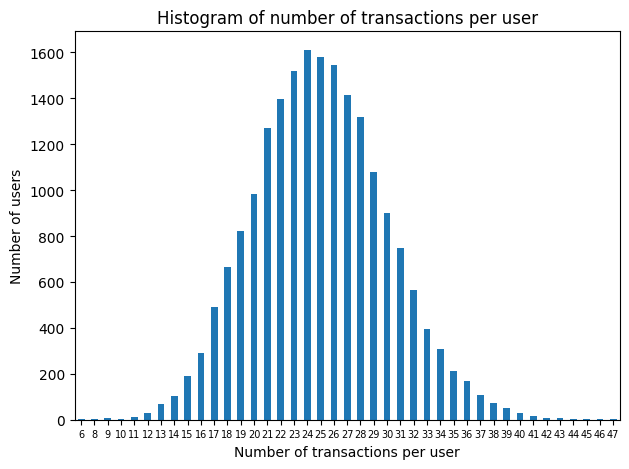

In [44]:
counts = df_merged.groupby('user_id').size()
hist = counts.value_counts().sort_index()

ax = hist.plot(kind='bar')
plt.xlabel('Number of transactions per user')
plt.ylabel('Number of users')
plt.title('Histogram of number of transactions per user')
plt.xticks(rotation=0, fontsize=7)

plt.tight_layout() 

plt.show()

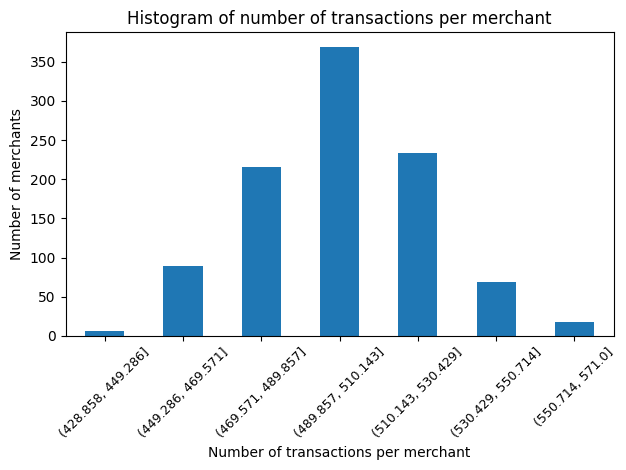

In [100]:
counts = df_merged.groupby('merchant_id').size()

counts_binned = pd.cut(counts, bins=7)

hist = counts_binned.value_counts().sort_index()

ax = hist.plot(kind='bar')
plt.xlabel('Number of transactions per merchant')
plt.ylabel('Number of merchants')
plt.title('Histogram of number of transactions per merchant')
plt.xticks(rotation=45, fontsize=9)
plt.tight_layout()
plt.show()

In nearly half of the observations, the values in the signup_date column are later than the corresponding transaction timestamp. This suggests that the **signup_date variable should be excluded from modeling**, as this information may not be available at the time of the transaction. Alternatively, these inconsistent values could be replaced with nulls.

In [37]:
df_merged['signup_date'] = pd.to_datetime(df_merged['signup_date'])
df_merged[df_merged['signup_date'] > df_merged['timestamp']]

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,user_country,signup_date,risk_score,category,merchant_country,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,...,Sweden,2022-08-10,0.426675,travel,France,0.581711,3,74.97,23,1
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,...,France,2024-05-22,0.729627,electronics,Germany,0.568933,2,56.92,23,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,...,Austria,2023-06-01,0.524168,gaming,Spain,0.450223,4,60.61,82,0
6,TX000006,2022-01-04 06:58:00,U19788,M0624,7.09,mobile,EUR,Web,"{'lat': 35.045793, 'long': 24.385632}",credit_card,...,Poland,2024-11-26,0.429032,electronics,Finland,0.908666,5,177.76,48,1
8,TX000008,2022-02-26 02:35:00,U05018,M0983,54.15,mobile,EUR,Android,"{'lat': 48.381147, 'long': -6.505085}",credit_card,...,Poland,2024-04-17,0.582572,clothing,Sweden,0.900372,2,134.24,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499988,TX499988,2023-01-12 21:14:00,U16974,M0243,107.19,online,EUR,Android,"{'lat': 69.851341, 'long': -4.52927}",mobile_payment,...,Sweden,2024-08-27,0.556321,education,Spain,0.972907,1,230.92,21,1
499991,TX499991,2022-05-29 00:47:00,U01425,M0102,16.11,online,EUR,Web,"{'lat': 52.757929, 'long': 13.246283}",credit_card,...,Denmark,2022-08-22,0.613210,restaurants,Italy,0.416960,2,18.74,92,1
499993,TX499993,2022-05-02 05:28:00,U15120,M0953,34.01,mobile,EUR,iOS,"{'lat': 62.162089, 'long': 2.7318059999999997}",credit_card,...,Portugal,2022-08-21,0.492759,gaming,Austria,0.299976,3,159.94,43,1
499997,TX499997,2022-08-06 13:14:00,U07750,M0215,77.65,in-store,EUR,iOS,"{'lat': 46.172673, 'long': 35.355061}",bank_transfer,...,Czech Republic,2023-10-26,0.592257,education,Spain,0.797026,4,15.81,111,1


In [6]:
def create_bar_plot_for_categorical_variables(data: pd.DataFrame, variable: str, ax: Axes = None) -> None:
    """
    Creates a combined bar and line plot showing:
    - The percentage distribution of each category in the selected variable.
    - The percentage of the positive class (e.g. fraud) per category.

    Parameters:
    - data (DataFrame): The input dataset containing the variable and binary target.
    - variable (str): The categorical variable to visualize.
    - ax (Axes, optional): Matplotlib Axes object to draw on. If None, a new figure is created.
    """
    data_summary = calculate_category_percentages(data, variable)
    class_summary = calculate_positive_class_percentages(data, variable)
    combined_data = pd.merge(data_summary, class_summary, on=variable, how='left')

    if ax is None:
        fig, ax = plt.subplots()

    x = np.arange(len(combined_data))
    labels = combined_data[variable]

    ax.bar(x, combined_data['percentage'], color='lightblue')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(variable)

    ax2 = ax.twinx()
    ax2.plot(x, combined_data['positive_percentage'], color='red', linewidth=2)

def create_bar_plot_for_numerical_variables(
    data: pd.DataFrame,
    variable: str,
    ax: Optional[plt.Axes] = None
) -> None:
    """
    Visualizes a numerical variable by applying optimal binning and plotting:
    - Percentage distribution per bin.
    - Positive class percentage per bin.

    Parameters:
    - data (pd.DataFrame): Dataset containing the numerical variable and target.
    - variable (str): The numerical variable to bin and visualize.
    - ax (Axes, optional): Matplotlib Axes object to draw on. If None, a new figure is created.
    """
    data = data.copy()
    data[variable] = create_binned_category(data, variable)
    
    create_bar_plot_for_categorical_variables(data=data, variable=variable, ax=ax)


def calculate_category_percentages(data: pd.DataFrame, variable: str) -> pd.DataFrame:
    """
    Calculates the percentage of observations in each category of a given variable.

    Parameters:
    - data (pd.DataFrame): Input dataset.
    - variable (str): The categorical variable.

    Returns:
    - pd.DataFrame: DataFrame with 'total_count' and 'percentage' columns per category.
    """
    summary = data.groupby(variable).size().reset_index(name='total_count')
    summary['percentage'] = summary['total_count'] / summary['total_count'].sum() * 100
    return summary

def calculate_positive_class_percentages(data: pd.DataFrame, variable: str, target: str = 'is_fraud') -> pd.DataFrame:
    """
    Calculates the percentage of positive class instances for each category of the given variable.

    Parameters:
    - data (pd.DataFrame): Input dataset.
    - variable (str): The categorical variable.
    - target (str): The name of the binary target column (default: 'is_fraud').

    Returns:
    - pd.DataFrame: DataFrame with positive class percentages per category.
    """
    summary = data.groupby([variable, target]).size().unstack(fill_value=0).reset_index()
    summary['positive_percentage'] = summary.get(1, 0) / (summary.get(0, 0) + summary.get(1, 0)) * 100
    return summary[[variable, 'positive_percentage']]

def create_binned_category(data: pd.DataFrame, variable: str) -> pd.Series:
    """
    Applies optimal binning to a numerical variable and returns a Series of bin labels.

    Parameters:
    - data (pd.DataFrame): Dataset with the numerical variable and binary target.
    - variable (str): The numerical variable to bin.

    Returns:
    - pd.Series: Categorical bin labels for the variable.
    """
    optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
    optb.fit(data[variable].values, data["is_fraud"].values)
    splits = optb.splits
    min_val = data[variable].min()
    max_val = data[variable].max()

    return data[variable].apply(lambda x: get_category_label(x, splits, min_val, max_val))

def get_category_label(value: float, splits: np.ndarray, min_val: float, max_val: float) -> str:
    """
    Assigns a bin label to a given value based on provided split points.

    Parameters:
    - value (float): The value to bin.
    - splits (np.ndarray): The array of split points.
    - min_val (float): Minimum value in the original data.
    - max_val (float): Maximum value in the original data.

    Returns:
    - str: Bin label in string format.
    """
    for i, split in enumerate(splits):
        if i == 0:
            if value < split:
                return f"[{min_val:.2f}, {split:.2f})"
        elif i == len(splits) - 1:
            if value >= split:
                return f"[{splits[-1]:.2f}, {max_val:.2f}]"
            else:
                return f"[{splits[i-1]:.2f}, {split:.2f})"
        elif splits[i-1] <= value < split:
            return f"[{splits[i-1]:.2f}, {split:.2f})"
    return "Unknown"

To visualize the variables used in the modeling process, it was decided to present the distributions of the explanatory variables along with the proportion of the positive class across categories or value intervals. The blue bars represent the percentage share of each category in the dataset and correspond to the left vertical axis. The red line depicts the percentage of observations classified as positive within each category and corresponds to the right vertical axis.

These plots serve as a tool for identifying potential patterns or associations between individual explanatory variables and the target variable. It is important to note, however, that such visualizations capture only marginal relationships and may not reflect more complex interactions between variables. Their purpose is to provide an initial intuition about the structure of the data rather than definitive conclusions.

Additionally, one should interpret the right-side scale with caution, as its range is determined independently for each plot. Consequently, apparent large differences in the red line may represent relatively small actual differences in class proportions.

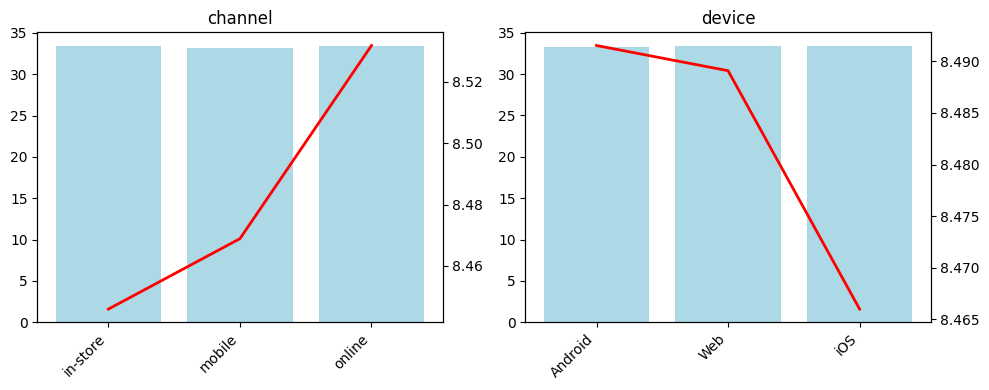

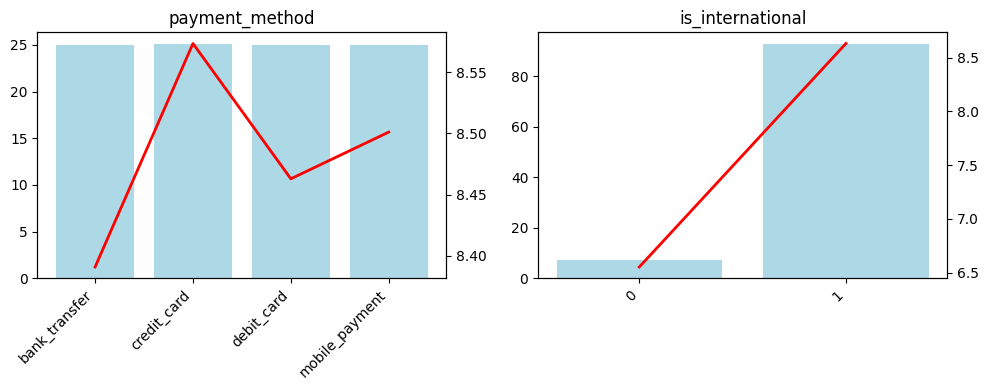

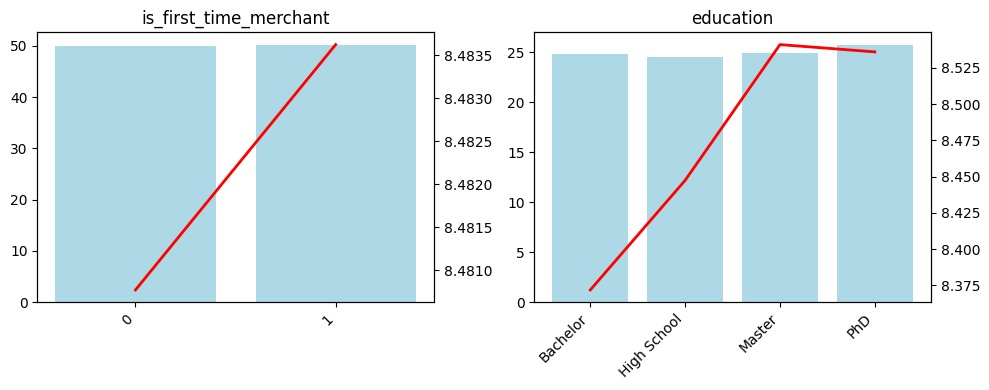

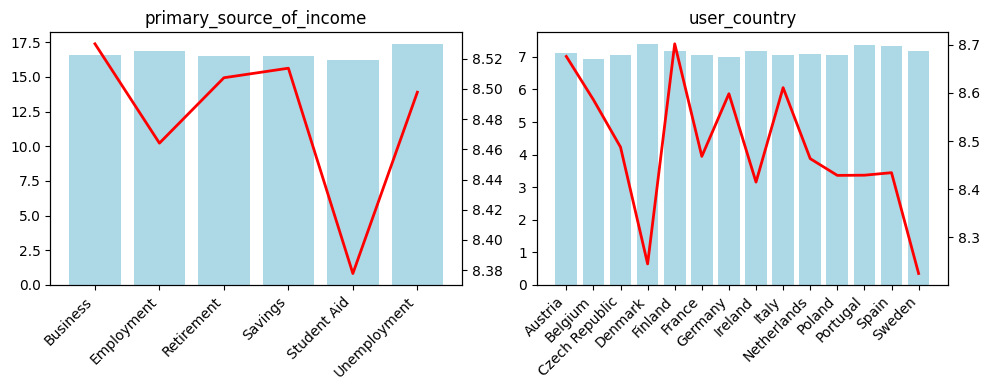

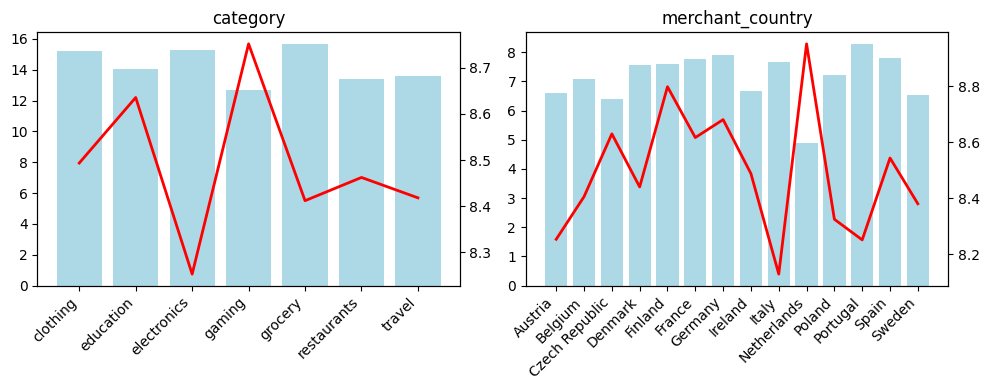

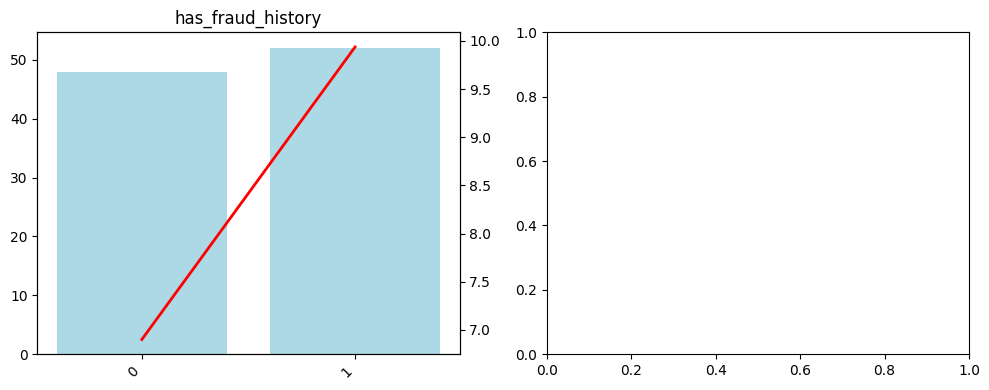

In [8]:
categorical_variables = ['channel', 'device', 'payment_method',
       'is_international', 'is_first_time_merchant', 'education', 'primary_source_of_income',
       'user_country', 'category',
       'merchant_country',
       'has_fraud_history']

categorical_variables_pairs = list(zip_longest(categorical_variables[::2], categorical_variables[1::2]))

for pair in categorical_variables_pairs:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    for i, variable in enumerate(pair):
        if variable is None:
            continue
        create_bar_plot_for_categorical_variables(df_merged, variable, ax=axs[i])
        
    plt.tight_layout()
    plt.show()

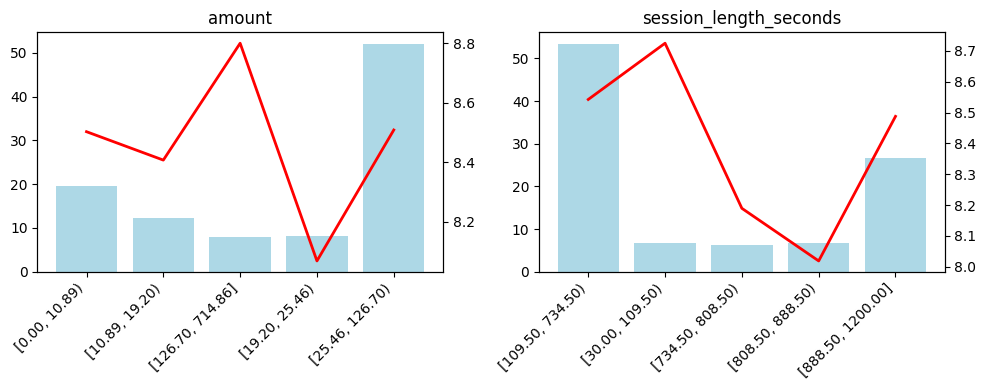

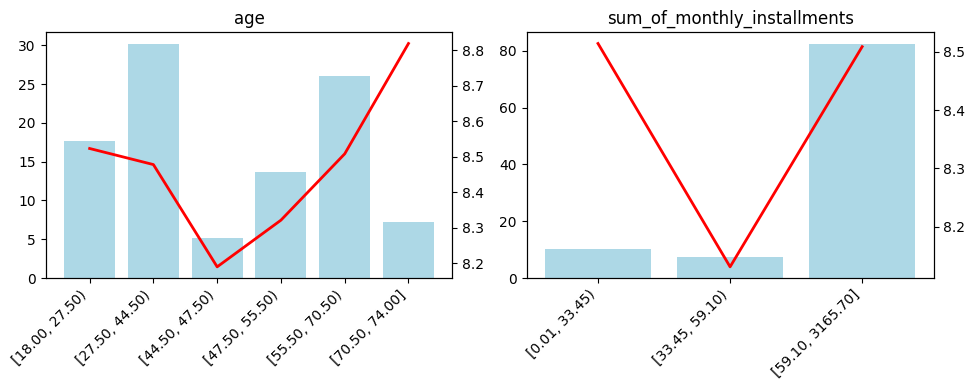

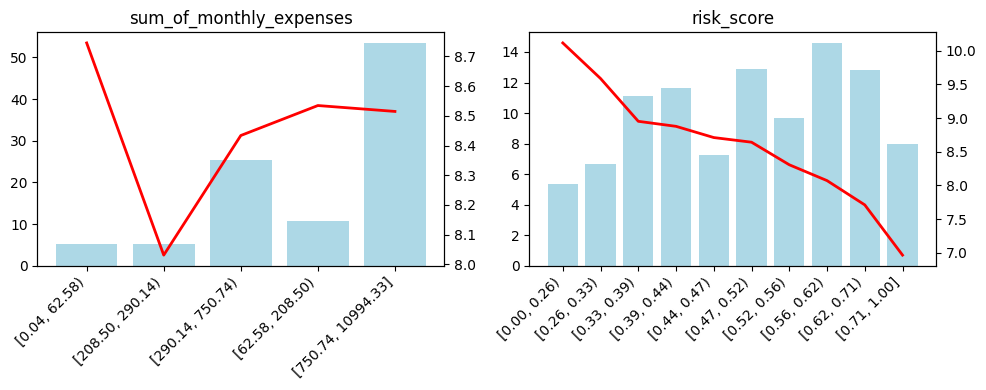

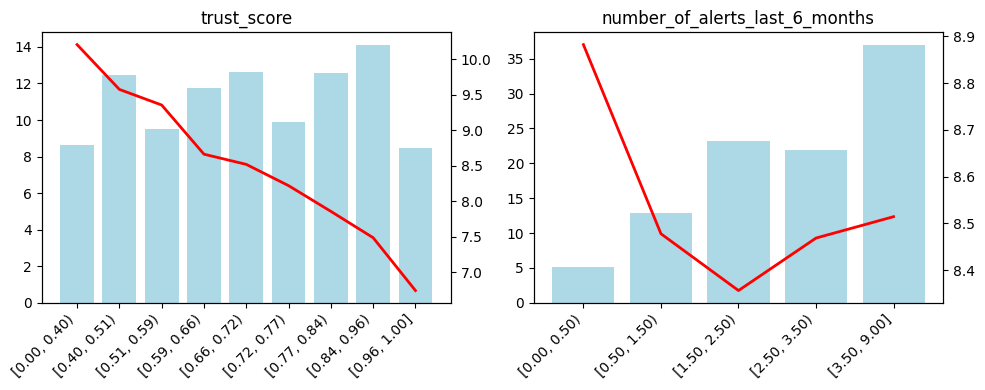

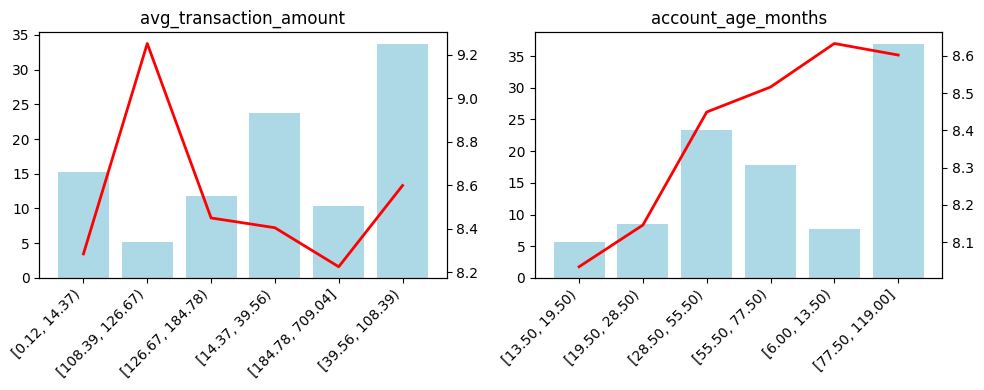

In [17]:
numerical_variables = ['amount', 'session_length_seconds', 'age',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses',
       'risk_score', 'trust_score','number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months']

numerical_variables_pairs = list(zip_longest(numerical_variables[::2], numerical_variables[1::2]))

for pair in numerical_variables_pairs:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    for i, variable in enumerate(pair):
        if variable is None:
            continue
        create_bar_plot_for_numerical_variables(df_merged, variable, ax=axs[i])
        
    plt.tight_layout()
    plt.show()
